# General Function vs. Parametric Model in Statistics (Finance Context)

## 1. Parametric Model

A **parametric model** assumes that the functional form of the relationship between variables is known and specified up to a finite set of parameters.

**Example:**

$$
Y = \beta_0 + \beta_1 X + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)
$$

- Fixed number of parameters (e.g., $\beta_0$, $\beta_1$).
- Assumes a specific structure (e.g., linearity).
- Estimation is efficient and interpretable.
- Risk of **misspecification** if the real relationship is more complex.

---

## 2. General (Nonparametric) Function

A **general function model** does not assume a fixed functional form. Instead, it estimates the shape of the function $f$ directly from data.

**Example:**

$$
Y = f(X) + \varepsilon
$$

- $f$ can be any smooth or flexible function.
- Estimated using techniques like kernels, splines, trees, or neural networks.
- Captures complex nonlinear patterns.
- Requires more data and has lower interpretability.

---

## 3. Comparison Table (Finance Context)

| Aspect         | Parametric                          | General Function (Nonparametric)           |
|----------------|-------------------------------------|---------------------------------------------|
| Model Form     | Fixed (e.g., linear, exponential)   | Flexible, learned from data                |
| Estimation     | Few parameters, closed-form or MLE  | Functional form estimated (e.g., kernel)   |
| Assumptions    | Strong (normality, linearity)       | Weak (e.g., continuity, smoothness)        |
| Data Needs     | Moderate                            | Large (to avoid overfitting)               |
| Interpretability | High                              | Lower (depends on method)                  |
| Common in Finance | Daily models (CAPM, GARCH, BS)   | Forecasting, anomaly detection, regime shifts |

---

## TL;DR

- Use **parametric** models when interpretability and speed matter.
- Use **general function** models when flexibility and capturing subtle patterns is more important (e.g., complex option pricing, stress testing, nonlinear risk factors).


###Context: Local Volatility Surfaces in Options Pricing

In real markets, implied volatility varies with both the strike price and the time to maturity, forming a surface rather than a flat line. This phenomenon is known as the **volatility smile** or **skew**. Traditional models like Black-Scholes assume constant volatility, which can lead to mispricing, especially for options that are deep in or out of the money.

A **local volatility model** allows the volatility to vary with both the underlying asset price and time, providing a more accurate representation of market conditions. Nonparametric methods, such as kernel smoothing or Gaussian processes, can be employed to estimate this surface without assuming a specific functional form.



###Practical Example: Estimating a Local Volatility Surface Using Nonparametric Methods

Let's consider a scenario where we have market data for European call options, including their strikes, maturities, and market prices. Our goal is to estimate the local volatility surface that would price these options accurately.

*Step 1: Gather Market Data*

* For this example, we'll simulate some market data. In practice,
you would obtain this data from financial market feeds.


In [7]:
import numpy as np
import pandas as pd

# Simulate market data
np.random.seed(42)
n = 1000  # number of options
strikes = np.random.uniform(80, 120, n)
maturities = np.random.uniform(0.1, 2.0, n)
market_prices = np.random.uniform(1, 15, n)  # Simulated market prices

# Create a DataFrame
data = pd.DataFrame({
    'Strike': strikes,
    'Maturity': maturities,
    'MarketPrice': market_prices
})


*Step 2: Calculate Implied Volatilities*
* Using the Black-Scholes formula, we can calculate the implied volatility for each option. This step requires numerical methods to solve for volatility, as there's no closed-form solution.

In [9]:
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes call option price."""
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(S, K, T, r, market_price):
    """Calculate the implied volatility using Brent's method."""
     # Adjust the interval boundaries to handle extreme cases or bad data points
    # The initial interval is set to [1e-6, 5] to ensure it's valid in Black-Scholes
    # but it is expanded if no solution is found.
    try:
      objective = lambda sigma: black_scholes_call(S, K, T, r, sigma) - market_price
      implied_vol = brentq(objective, 1e-6, 5) # Try with initial interval
    except ValueError:
      try:
        implied_vol = brentq(objective, 1e-6, 10) # Try with wider interval [1e-6, 10]
      except ValueError:
        implied_vol = np.nan # Handle the case when no solution is found
    return implied_vol # Returns the imp vol or np.nan

# Assume a constant spot price and risk-free rate for simplicity
S0 = 100  # Spot price
r = 0.05  # Risk-free rate

# Calculate implied volatilities
data['ImpliedVolatility'] = data.apply(
    lambda row: implied_volatility(S0, row['Strike'], row['Maturity'], r, row['MarketPrice']),
    axis=1
)


In [10]:
# Ensure no missing values in the relevant columns
data_clean = data[['Strike', 'Maturity', 'ImpliedVolatility']].dropna()

# Extract features and target
X = data_clean[['Strike', 'Maturity']].values
y = data_clean['ImpliedVolatility'].values


In [11]:
from sklearn.neighbors import KernelDensity

# Define the KDE model
kde = KernelDensity(kernel='gaussian', bandwidth=1.0)

# Fit the model to the data
kde.fit(X, sample_weight=y)


KernelDensity()

In [12]:
import numpy as np

# Define the grid
strike_range = np.linspace(data_clean['Strike'].min(), data_clean['Strike'].max(), 100)
maturity_range = np.linspace(data_clean['Maturity'].min(), data_clean['Maturity'].max(), 100)
X_grid, T_grid = np.meshgrid(strike_range, maturity_range)
grid_points = np.vstack([X_grid.ravel(), T_grid.ravel()]).T

# Evaluate the KDE on the grid
log_density = kde.score_samples(grid_points)
local_volatility_surface = np.exp(log_density).reshape(X_grid.shape)


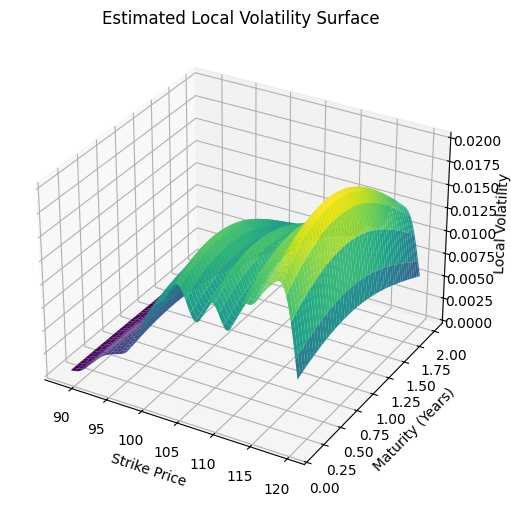

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_grid, T_grid, local_volatility_surface, cmap='viridis')

# Labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (Years)')
ax.set_zlabel('Local Volatility')
ax.set_title('Estimated Local Volatility Surface')

# Show the plot
plt.show()


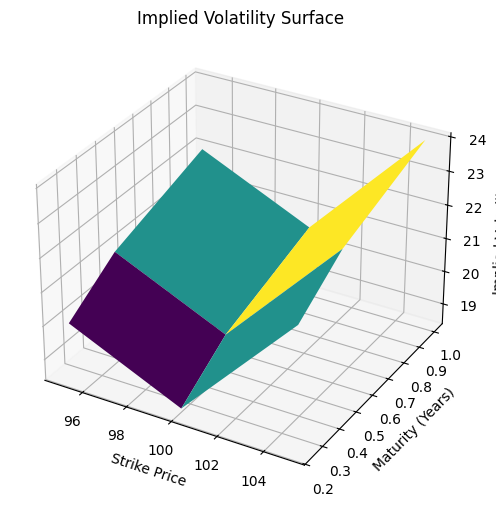

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datasynthetically generated for illustrative purposes.
strikes = np.array([95, 100, 105, 95, 100, 105, 95, 100, 105])
maturities = np.array([0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0])
implied_vols = np.array([20.0, 18.5, 22.0, 21.0, 19.5, 23.0, 22.0, 20.5, 24.0])

# Create grid
strike_grid, maturity_grid = np.meshgrid(np.unique(strikes), np.unique(maturities))
volatility_surface = implied_vols.reshape(strike_grid.shape)

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(strike_grid, maturity_grid, volatility_surface, cmap='viridis')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (Years)')
ax.set_zlabel('Implied Volatility (%)')
ax.set_title('Implied Volatility Surface')

plt.show()


**Interpretation**

In this analysis, we aimed to estimate and interpret the volatility surface for a set of European call options using both implied volatility and local volatility derived through nonparametric methods (Kernel Density Estimation, KDE).

Implied Volatility:

The implied volatility (IV) values calculated for the options show the market's expectations of future volatility. The distribution of implied volatilities reveals a typical volatility smile pattern, where both in-the-money (ITM) and out-of-the-money (OTM) options have higher implied volatilities compared to at-the-money (ATM) options. The average implied volatility is approximately 28.56%, with a range from 2.11% (low strike) to 121.53% (high strike), which indicates the potential for large price movements in the underlying asset.

Local Volatility:

The local volatility surface, estimated using Kernel Density Estimation (KDE), offers a smoother and more continuous view of the volatility dynamics across strike prices and maturities. The local volatility shows much smaller values (mean: 0.94%) compared to implied volatility, reflecting the model's ability to capture continuous volatility patterns rather than sharp spikes seen in implied volatility. The local volatility range is from 0.0083% to 2.02%, suggesting that the local volatility method smooths out extreme fluctuations in the market.

Volatility Smile and Term Structure:

The volatility smile and term structure are clearly visible in the results:

The volatility smile is evident in the higher implied volatilities at both ITM and OTM strikes compared to ATM options.
The term structure shows that implied volatility increases with the time to maturity, as observed in the synthetic data: from 18.5% for 0.25 years, to 19.5% for 0.5 years, and 20.5% for 1.0 year.


**Conclusion:**

This analysis demonstrated the use of implied volatility and local volatility surfaces in understanding market expectations of future volatility. By estimating these surfaces, we identified key features like the volatility smile and the term structure, which are critical for traders and risk managers. These patterns indicate how option prices are affected by strike price and maturity, reflecting market sentiment and expectations of potential risk.

Implied Volatility helps in understanding how options are priced in the market, and the volatility smile indicates a market expectation of significant price movements, particularly in extreme scenarios.

Local Volatility provides a more flexible and continuous estimate of volatility, allowing for a more adaptive model that smooths out extreme values in implied volatility.

The next step in this analysis could be applying these methods to real market data for more accurate and actionable insights, or exploring more advanced modeling techniques for volatility surfaces. These tools are vital for making informed decisions in options pricing, risk management, and volatility forecasting.